In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)


In [2]:
stock_dataset = pd.read_csv('Stock_Data.csv')
print(stock_dataset.head())

       Open      High       Low     Close  Adj Close     Volume        Date
0  1.156429  1.242857  1.145714  1.196429   1.196429  104790000  2002-05-23
1  1.214286  1.225000  1.197143  1.210000   1.210000   11104800  2002-05-24
2  1.213571  1.232143  1.157143  1.157143   1.157143    6609400  2002-05-28
3  1.164286  1.164286  1.085714  1.103571   1.103571    6757800  2002-05-29
4  1.107857  1.107857  1.071429  1.071429   1.071429   10154200  2002-05-30


In [3]:
stock_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5241 entries, 0 to 5240
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5241 non-null   float64
 1   High       5241 non-null   float64
 2   Low        5241 non-null   float64
 3   Close      5241 non-null   float64
 4   Adj Close  5241 non-null   float64
 5   Volume     5241 non-null   int64  
 6   Date       5241 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 286.7+ KB


In [4]:
stock_dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5.241000e+03
mean,122.076674,123.994434,120.076663,122.090193,122.090193,1.628071e+07
std,168.295608,170.741211,165.666677,168.245728,168.245728,1.895990e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,4.038571,4.120000,3.948571,4.035714,4.035714,6.179100e+06
50%,30.442858,30.968571,29.818571,30.415714,30.415714,1.042370e+07
75%,191.610001,194.490005,187.580002,190.850006,190.850006,1.939560e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.234140e+08


In [5]:
stock_dataset.sort_values(by=["Date"], inplace=True, ascending=True)
stock_dataset.Date.head()

0    2002-05-23
1    2002-05-24
2    2002-05-28
3    2002-05-29
4    2002-05-30
Name: Date, dtype: object

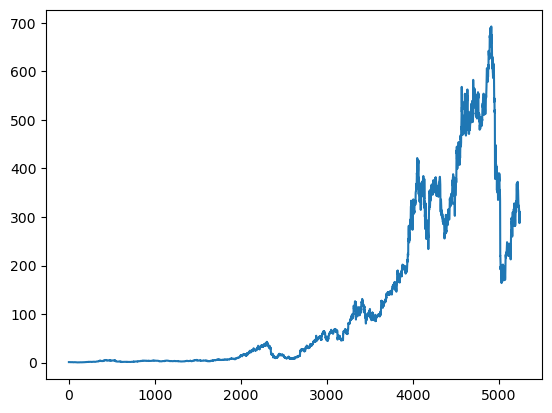

In [7]:
newopen = stock_dataset["Open"]
plt.plot(newopen)

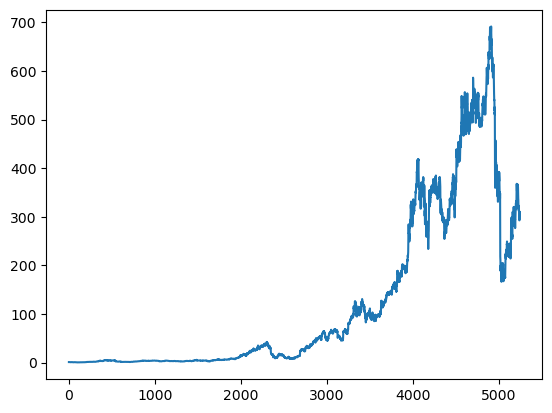

In [10]:
newclose = stock_dataset["Close"]
plt.plot(newclose)

# Feature Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
#Because we are going to make prediction on th basis of closing price
close_price = stock_dataset["Close"]

close_price = np.array(close_price).reshape(-1 , 1)
transformed_closed_value =  scaler.fit_transform(close_price)

df = transformed_closed_value

df.shape

(5241, 1)

In [15]:
training_length = int(0.6 * len(df))
testing_length  = int(len(df) - training_length)
training_data = df[:training_length]
testing_data  = df[training_length:]

In [17]:
len(training_data),len(testing_data)

(3144, 2097)

In [18]:
def create_dataset(dataset,time_step):
    X =[]
    Y =[]
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:i +time_step, 0])
        Y.append(dataset[i + time_step , 0])
    return np.array(X) , np.array(Y)

In [20]:
time_step = 100

X_train , Y_train = create_dataset(training_data , time_step)
X_test , Y_test   = create_dataset(testing_data , time_step)

In [28]:
print(X_train.shape),print(Y_train.shape),print(X_test.shape),print(Y_test.shape)

(3043, 100)
(3043,)
(1996, 100)
(1996,)


(None, None, None, None)

In [29]:
#reshaping in the 3d 

X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1] , 1)
X_test  = X_test.reshape(X_test.shape[0] , X_test.shape[1] , 1)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error as mse

In [35]:
mdl = Sequential()
mdl.add(LSTM(50, return_sequences=True, input_shape=(100, 1))) 

#inner layer
mdl.add(LSTM(50, return_sequences=True))
mdl.add(LSTM(50))
#output layer
mdl.add(Dense(1))

mdl.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
mdl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
model = mdl.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
48/48 [==============================] - 19s 272ms/step - loss: 1.1844e-04 - val_loss: 0.0045
Epoch 2/100
48/48 [==============================] - 10s 216ms/step - loss: 9.4658e-06 - val_loss: 0.0052
Epoch 3/100
48/48 [==============================] - 11s 232ms/step - loss: 9.7088e-06 - val_loss: 0.0043
Epoch 4/100
48/48 [==============================] - 11s 225ms/step - loss: 9.4856e-06 - val_loss: 0.0039
Epoch 5/100
48/48 [==============================] - 11s 230ms/step - loss: 8.5143e-06 - val_loss: 0.0039
Epoch 6/100
48/48 [==============================] - 11s 229ms/step - loss: 7.3271e-06 - val_loss: 0.0039
Epoch 7/100
48/48 [==============================] - 12s 243ms/step - loss: 6.7046e-06 - val_loss: 0.0031
Epoch 8/100
48/48 [==============================] - 11s 229ms/step - loss: 6.6665e-06 - val_loss: 0.0019
Epoch 9/100
48/48 [==============================] - 10s 216ms/step - loss: 6.9343e-06 - val_loss: 0.0032
Epoch 10/100
48/48 [==========================

In [42]:
# prediction for training and testing datasets
train_predict=mdl.predict(X_train)
test_predict=mdl.predict(X_test)

#transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

63/63 [==============================] - 3s 42ms/step


In [48]:
math.sqrt(mse(Y_train,train_predict))


22.279168372599287

In [46]:
math.sqrt(mse(Y_test,test_predict))

322.4330840144677

# Visualizing the Data and Prediction


Text(0, 0.5, 'Closing Price')

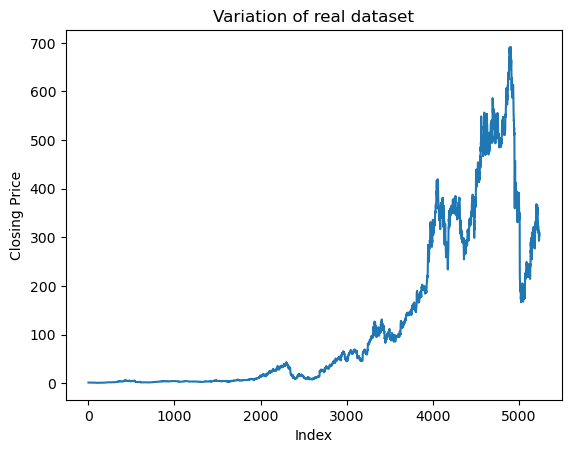

In [49]:
plt.plot(scaler.inverse_transform(df))
plt.title("Variation of real dataset")
plt.xlabel("Index")
plt.ylabel("Closing Price")

In [52]:
look_back =100

#shift train prediction for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shifting test prediction for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

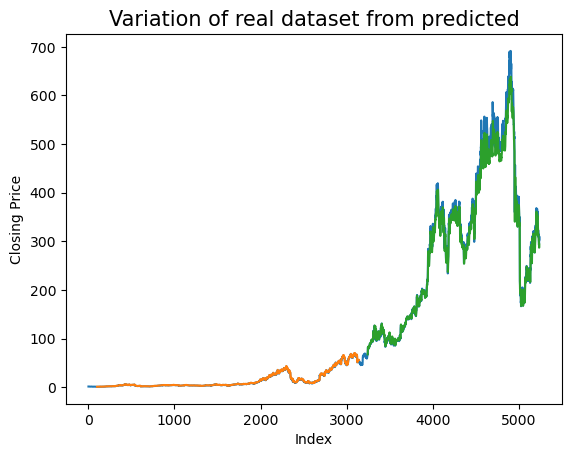

In [56]:
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Variation of real dataset from predicted",fontsize = "15")
plt.xlabel("Index")
plt.ylabel("Closing Price")
plt.show()

In [58]:
len(testing_data)

2097

In [59]:
x_input=testing_data[1997:].reshape(1,-1)
x_input.shape

(1, 100)

In [62]:
temp_input=list(x_input)
temp_input = temp_input[0].tolist()
len(temp_input)

100

In [70]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = mdl.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = mdl.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.42042518 0.43141869 0.42898856 0.42722381 0.4216692  0.41424858
 0.39435901 0.38865974 0.37669708 0.37352921 0.38055925 0.36782994
 0.39720864 0.4191378  0.43235892 0.44816935 0.44212289 0.42658734
 0.4160278  0.41178948 0.41416179 0.42111952 0.41249831 0.40617705
 0.40587325 0.44141411 0.45793332 0.46293825 0.4516265  0.4414575
 0.44559456 0.44825614 0.46235965 0.45537296 0.46283698 0.45920621
 0.41954282 0.41997676 0.41649066 0.41633156 0.43046399 0.43016023
 0.42612444 0.41051659 0.39997149 0.42056984 0.42600874 0.42611001
 0.44702659 0.44744609 0.45590816 0.45535853 0.4732519  0.47284688
 0.47699836 0.48088949 0.47134249 0.47150158 0.45624088 0.49489174
 0.51647375 0.52574586 0.53171997 0.52725025 0.52131953 0.51023923
 0.51132412 0.52308428 0.53017224 0.52874016 0.52234659 0.52447297
 0.53008541 0.52382202 0.50192177 0.51813723 0.52014786 0.5222598
 0.50676761 0.50278969 0.48765917 0.48386931 0.46762494 0.4582226
 0.46672811 0.46542625 0.45291391 0.45059948 0.455372

In [73]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [74]:
len(df)

5241

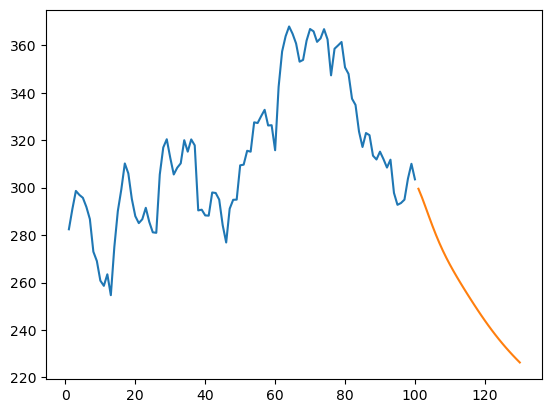

In [78]:
day_new_output=df[5141:]
plt.plot(day_new,scaler.inverse_transform(day_new_output))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

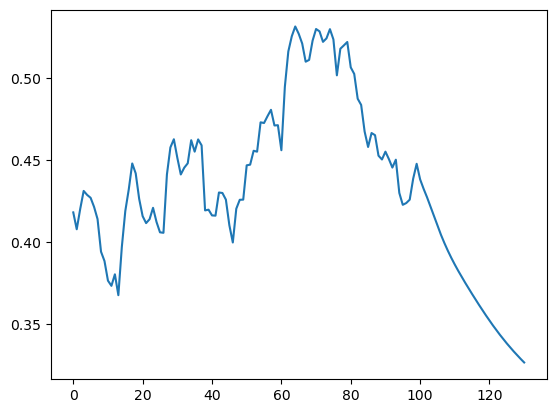

In [91]:
df2=df.tolist()
df2.extend(lst_output)
plt.plot(df2[5140:])

In [92]:
df2=scaler.inverse_transform(df2).tolist()

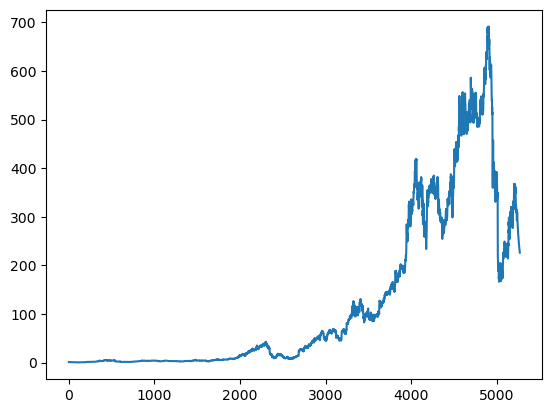

In [93]:
plt.plot(df2)